In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Tensorboard Directory

In [16]:
import os
import time
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

## Importing Data

In [17]:
mnist_data = keras.datasets.mnist.load_data()

In [18]:
X_train_full = mnist_data[0][0]/255
y_train_full = mnist_data[0][1]
X_test = mnist_data[1][0]/255
y_test = mnist_data[1][1]

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=10000)

In [20]:
X_train.shape

(50000, 28, 28)

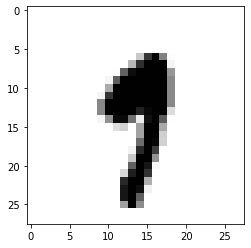

In [21]:
plt.imshow(X_train[0], cmap='binary')

## Creating our Model (Keras Wrapper)

In [22]:
# def build_model(n_hidden=1,n_neurons=100, learning_rate=0.01):
#     model = keras.models.Sequential()
#     model.add(keras.layers.Flatten(input_shape=[28,28]))
#     model.add(keras.layers.Dense(300, activation="relu"))
#     for layer in range(n_hidden):
#         model.add(keras.layers.Dense(n_neurons, activation="relu"))
#     model.add(keras.layers.Dense(10, activation="softmax"))
#     optimizer = keras.optimizers.SGD(lr=learning_rate)
#     model.compile(loss="sparse_categorical_crossentropy",
#               optimizer=optimizer,
#               metrics=["accuracy"])
#     return model

In [23]:
# keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)

## Callbacks

In [29]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [44]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('mnist_mlp.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
expon_lr = ExponentialLearningRate(factor=1.005)

## Creating our Model

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])

## Testing learning rates

In [33]:
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_val,y_val), callbacks=[expon_lr])

1563/1563 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.5096 - val_loss: nan - val_accuracy: 0.0975


Text(0, 0.5, 'Loss')

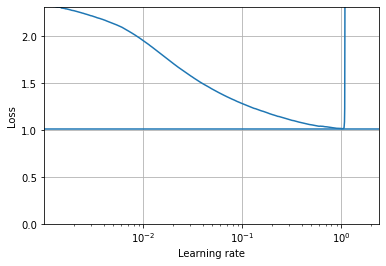

In [35]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

## Fitting the Final Model

In [36]:
keras.backend.clear_session()

In [37]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])

In [45]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0292 - accuracy: 0.9903 - val_loss: 0.1455 - val_accuracy: 0.9665
Epoch 2/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.0844 - val_accuracy: 0.9796
Epoch 3/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.1495 - val_accuracy: 0.9672
Epoch 4/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.0918 - val_accuracy: 0.9795
Epoch 5/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0146 - accuracy: 0.9950 - val_loss: 0.1028 - val_accuracy: 0.9765
Epoch 6/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0.4344 - val_accuracy: 0.9302
Epoch 7/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0843 - val_ac

In [46]:
model = keras.models.load_model("mnist_mlp.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 808us/step - loss: 0.1001 - accuracy: 0.9800


[0.10014127939939499, 0.9800000190734863]

## Fitting the Model (Keras Wrapper)

In [20]:
# from scipy.stats import reciprocal 
# from sklearn.model_selection import GridSearchCV

# param_distribs = {
#     "n_hidden":[1],
#     "n_neurons": [100],
#     "learning_rate": [0.001]
# }

In [21]:
# grid_search_cv = GridSearchCV(keras_reg, param_distribs, n_jobs=-1,cv=3,verbose=2)
# grid_search_cv.fit(X_train, y_train, epochs=30, validation_data=(X_val,y_val),
#                     callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Epoch 1/30
1563/1563 [==============================] - 3s 2ms/step - loss: 2.0553 - accuracy: 0.3441 - val_loss: 1.2602 - val_accuracy: 0.7598
Epoch 2/30
1563/1563 [==============================] - 2s 1ms/step - loss: 1.0865 - accuracy: 0.7784 - val_loss: 0.7436 - val_accuracy: 0.8316
Epoch 3/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.6840 - accuracy: 0.8397 - val_loss: 0.5649 - val_accuracy: 0.8592
Epoch 4/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.5391 - accuracy: 0.8646 - val_loss: 0.4796 - val_accuracy: 0.8764
Epoch 5/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.4625 - accuracy: 0.8803 - val_loss: 0.4309 - val_accuracy: 0.8860
Epoch 6/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.4157 - accuracy: 0.8874 - val_loss: 0.3988 - val_accuracy: 0.8941
Epoch 7/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.3907 - accuracy: 0.8944 - val_loss: 0.3758 - val_accuracy:

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd5c6d87040>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.001], 'n_hidden': [1],
                         'n_neurons': [100]},
             verbose=2)

In [ ]:
## keras = keras.models.load_model('mnist_mlp.h5')

In [17]:
# grid_search_cv.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [31]:
# from sklearn.metrics import accuracy_score

# y_pred = [np.argmax(instance) for instance in keras_reg.predict(X_test)]
# accuracy_score(y_pred, y_test)

0.9769

In [34]:
# import pandas as pd

# pd.DataFrame(history.history).plot()
# plt.grid(True)

## Saving the Model

In [14]:
model.save('mnist_mlp.h5')

In [ ]:
# model = keras.models.load_model('mnist_mlp.h5')

## Loading Tensorboard

In [47]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006